## General LSTM Model

This model use multiple features: price, trading volume, and TVL to predict coin prices

In [4]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 7.3 MB/s eta 0:00:00


In [5]:
# Import needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()
import shap

Instructions for updating:
non-resource variables are not supported in the long term


### Import the data

In [6]:
# Read the data based on coin
def read_data(coin):
    # Read csv
    df = pd.read_csv("data/" + coin + ".csv")

    # Covert to datetime
    df["Date"] = pd.to_datetime(df["Date"])
    return df

### Prepare data

In [7]:
def train_test_val(df, date_train, date_validation, features):
    # Split data into training, validation and test sets
    training_data = df[(df['Date'] <= date_train)][features]
    validation_data = df[(df['Date'] > date_train) & (df['Date'] <= date_validation)][features]
    test_data = df[(df['Date'] > date_validation)][features]

    print(training_data.head())

    # Reshape the data
    training_set = training_data.to_numpy()
    validation_set = validation_data.to_numpy()
    test_set = test_data.to_numpy()
    return training_set, validation_set, test_set

### Scale the features

In [8]:
def scale_features(scaler, training_set, validation_set, test_set):
    training_set_scaled = scaler.fit_transform(training_set)
    validation_set_scaled = scaler.transform(validation_set)
    test_set_scaled = scaler.transform(test_set)
    return training_set_scaled, validation_set_scaled, test_set_scaled

### Create Input sequences

In [9]:
def create_sequences(data, seq_length=60):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i,:])
        y.append(data[i,0])
    return np.array(X), np.array(y)

### Define the model

In [36]:
def define_model(optimizer, loss, seq_length=60, num_parameters=1):
    # Define the structure
    model = keras.Sequential()
    model.add(keras.layers.LSTM(units=50, return_sequences=True, input_shape=(seq_length, num_parameters)))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.LSTM(units=50, return_sequences=True))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.LSTM(units=50, return_sequences=True))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.LSTM(units=50))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(units=1))

    # Specify the parameters for the LSTM Model
    model.compile(optimizer=optimizer, loss=loss, metrics=[keras.metrics.MeanSquaredError(), keras.metrics.RootMeanSquaredError()])
    return model

### Train the model

In [11]:
def train_model(model, X_train, y_train, X_validation, y_validation, epochs=100):
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_validation, y_validation))
    return history

### Visualise the loss during training

In [12]:
def visualize_loss(history):
    # Plot loss during training
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

### Test the model

In [13]:
def test_model(model, data, X_test, y_test):
    history = model.evaluate(X_test, y_test)
    predicted_price = model.predict(X_test)

    # Fit scaler for the stock price
    feature_scaler = MinMaxScaler()
    feature_scaler.fit(data[:, 0].reshape(-1, 1))

    # Inverse transform the stock price
    predicted_price = feature_scaler.inverse_transform(predicted_price)
    return predicted_price, history

### Visualise results

In [14]:
# Results for one model
def visualize_results(df, predicted_price, date_validation, coin, seq_length=60):
    date_range = pd.date_range(start='2024-01-01', periods=len(predicted_price), freq='B')
    test_prices = df[(df['Date'] > date_validation)]['Adj Close']
    test_dates = df[(df['Date'] > date_validation)]["Date"]
    plt.figure(figsize=(10, 6))
    plt.plot(test_dates, test_prices, color='black', label=(coin + ' Price'))
    plt.plot(test_dates[seq_length:], predicted_price, color='green', label='Predicted ' + coin + ' Price')
    plt.gca().xaxis.set_major_locator(dates.MonthLocator(interval=1))  # Show tick marks for every 3 months
    plt.gca().xaxis.set_major_formatter(dates.DateFormatter('%b %Y'))  # Format x-axis labels as 'Jan 2023', 'Feb 2023', etc.
    plt.title(coin + ' Price Prediction')
    plt.xlabel('Time')
    plt.ylabel(coin + 'Price')
    plt.legend()
    plt.show()

In [15]:
# Comparing 2 models
def visualize_results2(df, predicted_price1, predicted_price2, date_validation, coin, seq_length=60):
    date_range = pd.date_range(start='2024-01-01', periods=len(predicted_price1), freq='B')
    test_prices = df[(df['Date'] > date_validation)]["Adj Close"]
    test_dates = df[(df['Date'] > date_validation)]["Date"]
    plt.figure(figsize=(10, 6))
    plt.plot(test_dates, test_prices, color='black', label=(coin + ' Price'))
    plt.plot(test_dates[seq_length:], predicted_price1, linestyle='--', color='orange', label='Predicted ' + coin + ' Price using Initial Features')
    plt.plot(test_dates[seq_length:], predicted_price2, color='green', label='Predicted ' + coin + ' Price | All Features')
    plt.gca().xaxis.set_major_locator(dates.MonthLocator(interval=1))  # Show tick marks for every 1 month
    plt.gca().xaxis.set_major_formatter(dates.DateFormatter('%b %Y'))  # Format x-axis labels as 'Jan 2023', 'Feb 2023', etc.
    plt.title(coin + ' Price Prediction')
    plt.xlabel('Time')
    plt.ylabel(coin + ' Price')
    plt.legend()
    plt.show()

### Test hit rate

In [ ]:
def calculate_hit_rate(test_prices, predicted_prices):
    hits = 0
    total_predictions = len(test_prices) - 1  # We compare changes, so one less than the number of prices

    for i in range(1, len(test_prices)):
        actual_movement = test_prices[i] - test_prices[i - 1]
        predicted_movement = predicted_prices[i] - predicted_prices[i - 1]

        if (actual_movement > 0 and predicted_movement > 0) or (actual_movement < 0 and predicted_movement < 0):
            hits += 1

    hit_rate = hits / total_predictions
    return hit_rate

## Make a custom run

In [28]:
# Define the parameters
coin = "ETH"
date_train = "2023-06-01"
date_validation = "2023-11-15"
features = ["Adj Close", "TVL", "sentiment_score", "normalized_influence_robust", "Volume"]
optimizer = "adam"
loss = "mean_squared_error"
seq_length = 40
epochs_train = 60

In [29]:
# Read the data
df = read_data(coin)

In [30]:
# Split the data
train, validation, test = train_test_val(df, date_train, date_validation, features)
print(train.shape)
print(validation.shape)
print(test.shape)

    Adj Close           TVL  sentiment_score  normalized_influence_robust  \
0  130.802002  6.031933e+08         0.548312                     3.988636   
1  127.410179  6.026967e+08         0.497812                     1.284091   
2  134.171707  5.971895e+08         0.125570                     2.972727   
3  135.069366  6.052853e+08         0.650860                     0.463636   
4  136.276779  6.071934e+08         0.357350                    -0.045455   

        Volume  
0   7935230330  
1   8032709256  
2  10476845358  
3   7430904515  
4   7526675353  
(1248, 5)
(167, 5)
(167, 5)


In [31]:
# Define the scaler
scaler = MinMaxScaler(feature_range=(0, 1))
summary_train = pd.DataFrame(train)
summary_train.describe()

,0,1,2,3,4
count,1248.000000,1.248000e+03,1248.000000,1248.000000,1.248000e+03
mean,1691.942042,3.774322e+10,0.395004,1.829003,1.762349e+10
std,1193.852506,3.038944e+10,0.172049,1.624436,1.028291e+10
min,110.605873,4.031925e+08,-0.210671,-0.227273,2.399675e+09
25%,449.149490,1.012162e+10,0.251717,0.751645,1.065473e+10
50%,1615.237426,2.945452e+10,0.419640,1.451022,1.571289e+10
75%,2522.957580,6.404018e+10,0.522287,2.538519,2.164114e+10
max,4812.087402,1.089997e+11,0.975100,20.021724,8.448291e+10


In [32]:
# Scale the features
train_scaled, validation_scaled, test_scaled = scale_features(scaler, train, validation, test)
summary_train_scaled = pd.DataFrame(train_scaled)
summary_train_scaled.describe()

,0,1,2,3,4
count,1248.000000,1248.000000,1248.000000,1248.000000,1248.000000
mean,0.336348,0.343842,0.510786,0.101550,0.185468
std,0.253931,0.279838,0.145095,0.080223,0.125274
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.072008,0.089491,0.389947,0.048344,0.100569
50%,0.320033,0.267516,0.531563,0.082883,0.162192
75%,0.513105,0.585995,0.618128,0.136589,0.234414
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [33]:
# Create sequences for LSTM
X_train, y_train = create_sequences(train_scaled, seq_length=seq_length)
X_validation, y_validation = create_sequences(validation_scaled, seq_length=seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length=seq_length)
print(X_train.shape, y_train.shape)
print(X_validation.shape, y_validation.shape)
print(X_test.shape, y_test.shape)

(1208, 40, 5) (1208,)
(127, 40, 5) (127,)
(127, 40, 5) (127,)


In [34]:
# Reshape inputs for LSTM
y_train = np.reshape(y_train, (-1, 1))
y_test = np.reshape(y_test, (-1, 1))
y_validation = np.reshape(y_validation, (-1, 1))
print(X_train.shape, y_train.shape)
print(X_validation.shape, y_validation.shape)
print(X_test.shape, y_test.shape)

(1208, 40, 5) (1208, 1)
(127, 40, 5) (127, 1)
(127, 40, 5) (127, 1)


In [37]:
# Define the model
model = define_model(optimizer, loss, seq_length=seq_length, num_parameters=len(features))
model(tf.random.normal((1, seq_length, len(features))))

<tf.Tensor 'sequential_1/dense/BiasAdd:0' shape=(1, 1) dtype=float32>

In [38]:
# Train the model
history = train_model(model, X_train, y_train, X_validation, y_validation, epochs=epochs_train)

Train on 1208 samples, validate on 127 samples
Epoch 1/60
1208/1208 [==============================] - ETA: 0s - loss: 0.0303 - mean_squared_error: 0.0303 - root_mean_squared_error: 0.1741

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


1208/1208 [==============================] - 4s 3ms/sample - loss: 0.0303 - mean_squared_error: 0.0303 - root_mean_squared_error: 0.1741 - val_loss: 7.6291e-04 - val_mean_squared_error: 7.6292e-04 - val_root_mean_squared_error: 0.0276
Epoch 2/60
1208/1208 [==============================] - 3s 3ms/sample - loss: 0.0078 - mean_squared_error: 0.0078 - root_mean_squared_error: 0.0883 - val_loss: 0.0029 - val_mean_squared_error: 0.0029 - val_root_mean_squared_error: 0.0542
Epoch 3/60
1208/1208 [==============================] - 3s 3ms/sample - loss: 0.0066 - mean_squared_error: 0.0066 - root_mean_squared_error: 0.0814 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - val_root_mean_squared_error: 0.0503
Epoch 4/60
1208/1208 [==============================] - 3s 2ms/sample - loss: 0.0068 - mean_squared_error: 0.0068 - root_mean_squared_error: 0.0827 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - val_root_mean_squared_error: 0.0770
Epoch 5/60
1208/1208 [=============================

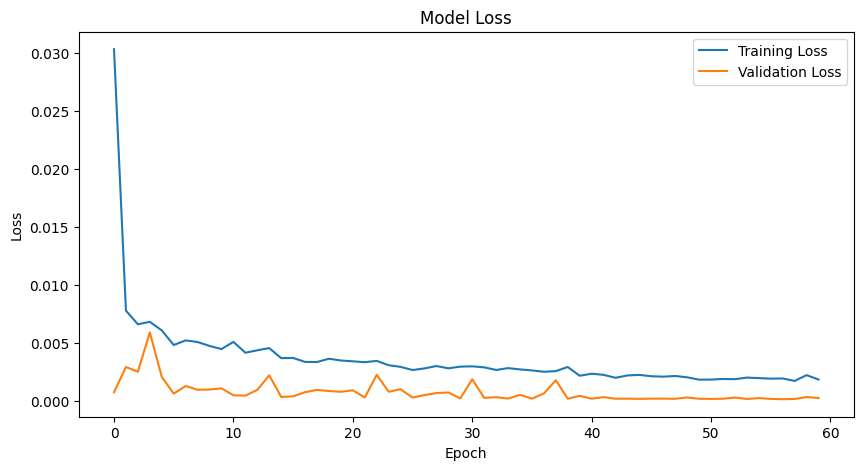

In [39]:
# Visualize loss
visualize_loss(history)

In [40]:
# Test the model
predicted_price, history = test_model(model, train, X_test, y_test)
print(predicted_price.shape)
print(predicted_price[0:10])
print(model.metrics_names)
print(history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


(127, 1)
[[2320.9614]
 [2323.7783]
 [2327.4492]
 [2335.9873]
 [2342.286 ]
 [2344.3203]
 [2339.43  ]
 [2338.3884]
 [2343.3972]
 [2334.6453]]
['loss', 'mean_squared_error', 'root_mean_squared_error']
[0.0009355591399243145, 0.0009355591, 0.030586911]


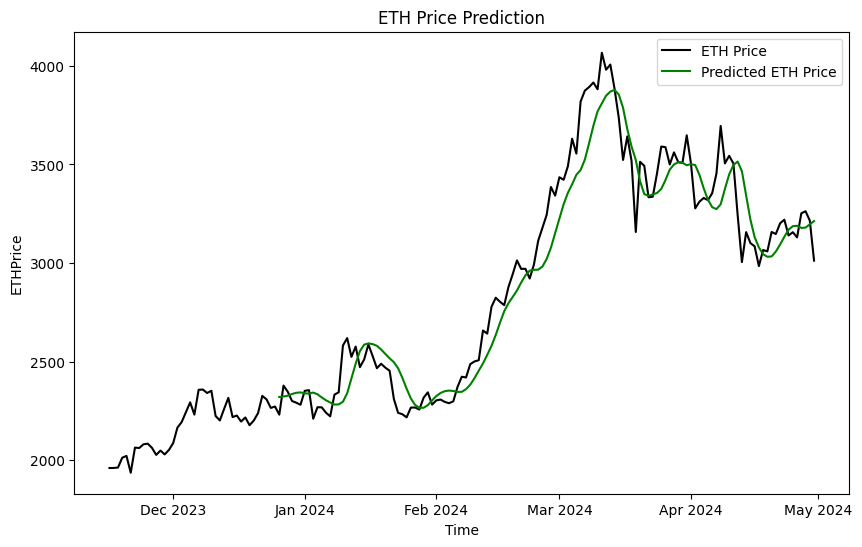

In [41]:
visualize_results(df, predicted_price, date_validation, coin, seq_length=seq_length)

In [44]:
# Test hit rate
test_prices = df[(df['Date'] > date_validation)]["Adj Close"]
test_prices = test_prices.to_numpy()
hit_rate = calculate_hit_rate(test_prices[seq_length:], predicted_price)
print(hit_rate)

0.5793650793650794


In [ ]:
explainer = shap.DeepExplainer(model, X_train)
shap_values = explainer(X_test)

/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


In [ ]:
print(shap_values.shape)

(120, 40, 5, 1)


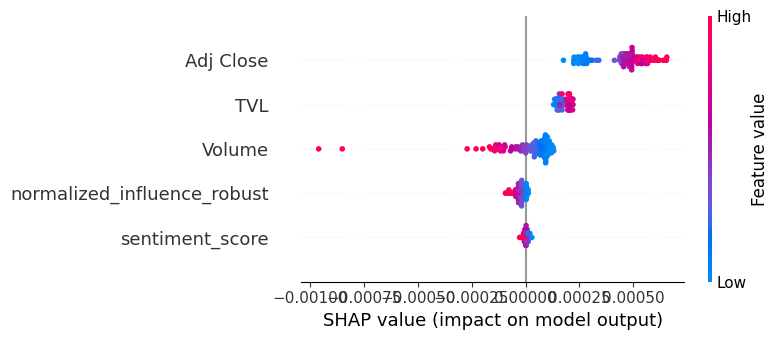

In [ ]:
shap.summary_plot(shap_values[:,0,:,0], feature_names=features)

### Run the loop to test hyperparameters

In [ ]:
def run_model_with_configs(coin, date_train, date_validation, features_list, seq_length_list, epochs_list):
  history_dict = {}
  df = read_data(coin)

  for features in features_list:
    for seq_length in seq_length_list:
      for epochs in epochs_list:
        train, validation, test = train_test_val(df, date_train, date_validation, features)
        scaler = MinMaxScaler(feature_range=(0, 1))
        train_scaled, validation_scaled, test_scaled = scale_features(scaler, train, validation, test)
        X_train, y_train = create_sequences(train_scaled, seq_length=seq_length)
        X_validation, y_validation = create_sequences(validation_scaled, seq_length=seq_length)
        X_test, y_test = create_sequences(test_scaled, seq_length=seq_length)
        y_train = np.reshape(y_train, (-1, 1))
        y_test = np.reshape(y_test, (-1, 1))
        y_validation = np.reshape(y_validation, (-1, 1))

        # Define, train and test the model
        model = define_model(optimizer, loss, seq_length=seq_length, num_parameters=len(features))
        train_model(model, X_train, y_train, X_validation, y_validation, epochs=epochs)
        predicted_price, history = test_model(model, train, X_test, y_test)

        # Store history with a key representing the configuration
        key = (tuple(features), seq_length, epochs)
        history_dict[key] = history

  return history_dict


features_list = [["Adj Close", "TVL", "sentiment_score", "normalized_influence_robust", "Volume"]]
seq_length_list = [40, 60, 80, 100]
epochs_list = [60]
coin = "ETH_12h"

history_dict = run_model_with_configs(coin, date_train, date_validation, features_list, seq_length_list, epochs_list)

print(history_dict)

   Adj Close           TVL  sentiment_score  normalized_influence_robust  \
0     128.87  6.031933e+08         0.491250                     0.977273   
1     131.61  6.029450e+08         0.567333                     4.992424   
2     130.67  6.026967e+08         0.008000                     2.045455   
3     129.96  5.999431e+08         0.791700                     0.827273   
4     127.07  5.971895e+08         0.214620                     3.318182   

       Volume  
0  7769.17336  
1  4163.30667  
2  3772.66670  
3  3718.46074  
4  7303.34389  


Train on 2559 samples, validate on 266 samples
Epoch 1/60
2559/2559 [==============================] - ETA: 0s - loss: 0.0129 - mean_squared_error: 0.0129 - root_mean_squared_error: 0.1138

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


2559/2559 [==============================] - 9s 3ms/sample - loss: 0.0129 - mean_squared_error: 0.0129 - root_mean_squared_error: 0.1138 - val_loss: 0.0012 - val_mean_squared_error: 0.0012 - val_root_mean_squared_error: 0.0346
Epoch 2/60
2559/2559 [==============================] - 7s 3ms/sample - loss: 0.0045 - mean_squared_error: 0.0045 - root_mean_squared_error: 0.0673 - val_loss: 0.0017 - val_mean_squared_error: 0.0017 - val_root_mean_squared_error: 0.0414
Epoch 3/60
2559/2559 [==============================] - 9s 4ms/sample - loss: 0.0042 - mean_squared_error: 0.0042 - root_mean_squared_error: 0.0650 - val_loss: 0.0030 - val_mean_squared_error: 0.0030 - val_root_mean_squared_error: 0.0550
Epoch 4/60
2559/2559 [==============================] - 7s 3ms/sample - loss: 0.0036 - mean_squared_error: 0.0036 - root_mean_squared_error: 0.0599 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - val_root_mean_squared_error: 0.0510
Epoch 5/60
2559/2559 [==============================] - 8s 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


   Adj Close           TVL  sentiment_score  normalized_influence_robust  \
0     128.87  6.031933e+08         0.491250                     0.977273   
1     131.61  6.029450e+08         0.567333                     4.992424   
2     130.67  6.026967e+08         0.008000                     2.045455   
3     129.96  5.999431e+08         0.791700                     0.827273   
4     127.07  5.971895e+08         0.214620                     3.318182   

       Volume  
0  7769.17336  
1  4163.30667  
2  3772.66670  
3  3718.46074  
4  7303.34389  


Train on 2539 samples, validate on 246 samples
Epoch 1/60
2539/2539 [==============================] - ETA: 0s - loss: 0.0154 - mean_squared_error: 0.0154 - root_mean_squared_error: 0.1240

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


2539/2539 [==============================] - 12s 5ms/sample - loss: 0.0154 - mean_squared_error: 0.0154 - root_mean_squared_error: 0.1240 - val_loss: 0.0041 - val_mean_squared_error: 0.0041 - val_root_mean_squared_error: 0.0639
Epoch 2/60
2539/2539 [==============================] - 11s 4ms/sample - loss: 0.0042 - mean_squared_error: 0.0042 - root_mean_squared_error: 0.0649 - val_loss: 8.3556e-04 - val_mean_squared_error: 8.3556e-04 - val_root_mean_squared_error: 0.0289
Epoch 3/60
2539/2539 [==============================] - 12s 5ms/sample - loss: 0.0038 - mean_squared_error: 0.0038 - root_mean_squared_error: 0.0617 - val_loss: 4.5861e-04 - val_mean_squared_error: 4.5861e-04 - val_root_mean_squared_error: 0.0214
Epoch 4/60
2539/2539 [==============================] - 12s 5ms/sample - loss: 0.0034 - mean_squared_error: 0.0034 - root_mean_squared_error: 0.0583 - val_loss: 7.8240e-04 - val_mean_squared_error: 7.8240e-04 - val_root_mean_squared_error: 0.0280
Epoch 5/60
2539/2539 [=========

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


   Adj Close           TVL  sentiment_score  normalized_influence_robust  \
0     128.87  6.031933e+08         0.491250                     0.977273   
1     131.61  6.029450e+08         0.567333                     4.992424   
2     130.67  6.026967e+08         0.008000                     2.045455   
3     129.96  5.999431e+08         0.791700                     0.827273   
4     127.07  5.971895e+08         0.214620                     3.318182   

       Volume  
0  7769.17336  
1  4163.30667  
2  3772.66670  
3  3718.46074  
4  7303.34389  


Train on 2519 samples, validate on 226 samples
Epoch 1/60
2519/2519 [==============================] - ETA: 0s - loss: 0.0130 - mean_squared_error: 0.0130 - root_mean_squared_error: 0.1139

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


2519/2519 [==============================] - 17s 7ms/sample - loss: 0.0130 - mean_squared_error: 0.0130 - root_mean_squared_error: 0.1139 - val_loss: 0.0011 - val_mean_squared_error: 0.0011 - val_root_mean_squared_error: 0.0325
Epoch 2/60
2519/2519 [==============================] - 15s 6ms/sample - loss: 0.0044 - mean_squared_error: 0.0044 - root_mean_squared_error: 0.0666 - val_loss: 3.9041e-04 - val_mean_squared_error: 3.9041e-04 - val_root_mean_squared_error: 0.0198
Epoch 3/60
2519/2519 [==============================] - 15s 6ms/sample - loss: 0.0040 - mean_squared_error: 0.0040 - root_mean_squared_error: 0.0634 - val_loss: 0.0021 - val_mean_squared_error: 0.0021 - val_root_mean_squared_error: 0.0460
Epoch 4/60
2519/2519 [==============================] - 15s 6ms/sample - loss: 0.0036 - mean_squared_error: 0.0036 - root_mean_squared_error: 0.0600 - val_loss: 2.9593e-04 - val_mean_squared_error: 2.9593e-04 - val_root_mean_squared_error: 0.0172
Epoch 5/60
2519/2519 [=================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


   Adj Close           TVL  sentiment_score  normalized_influence_robust  \
0     128.87  6.031933e+08         0.491250                     0.977273   
1     131.61  6.029450e+08         0.567333                     4.992424   
2     130.67  6.026967e+08         0.008000                     2.045455   
3     129.96  5.999431e+08         0.791700                     0.827273   
4     127.07  5.971895e+08         0.214620                     3.318182   

       Volume  
0  7769.17336  
1  4163.30667  
2  3772.66670  
3  3718.46074  
4  7303.34389  


Train on 2499 samples, validate on 206 samples
Epoch 1/60
2499/2499 [==============================] - ETA: 0s - loss: 0.0160 - mean_squared_error: 0.0160 - root_mean_squared_error: 0.1263

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


2499/2499 [==============================] - 21s 8ms/sample - loss: 0.0160 - mean_squared_error: 0.0160 - root_mean_squared_error: 0.1263 - val_loss: 0.0057 - val_mean_squared_error: 0.0057 - val_root_mean_squared_error: 0.0752
Epoch 2/60
2499/2499 [==============================] - 20s 8ms/sample - loss: 0.0044 - mean_squared_error: 0.0044 - root_mean_squared_error: 0.0662 - val_loss: 0.0035 - val_mean_squared_error: 0.0035 - val_root_mean_squared_error: 0.0588
Epoch 3/60
2499/2499 [==============================] - 20s 8ms/sample - loss: 0.0050 - mean_squared_error: 0.0050 - root_mean_squared_error: 0.0707 - val_loss: 0.0019 - val_mean_squared_error: 0.0019 - val_root_mean_squared_error: 0.0442
Epoch 4/60
2499/2499 [==============================] - 20s 8ms/sample - loss: 0.0033 - mean_squared_error: 0.0033 - root_mean_squared_error: 0.0572 - val_loss: 0.0011 - val_mean_squared_error: 0.0011 - val_root_mean_squared_error: 0.0339
Epoch 5/60
2499/2499 [==============================] -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


{(('Adj Close', 'TVL', 'sentiment_score', 'normalized_influence_robust', 'Volume'), 40, 60): [0.0006080534518696368, 0.0006080534, 0.02465874], (('Adj Close', 'TVL', 'sentiment_score', 'normalized_influence_robust', 'Volume'), 60, 60): [0.001051710112692995, 0.0010517101, 0.03243008], (('Adj Close', 'TVL', 'sentiment_score', 'normalized_influence_robust', 'Volume'), 80, 60): [0.00048607932403683663, 0.0004860793, 0.022047207], (('Adj Close', 'TVL', 'sentiment_score', 'normalized_influence_robust', 'Volume'), 100, 60): [0.0005713012277348233, 0.0005713012, 0.023901908]}


In [ ]:
history_dict

{(('Adj Close',
   'TVL',
   'sentiment_score',
   'normalized_influence_robust',
   'Volume'),
  40,
  60): [0.0006080534518696368, 0.0006080534, 0.02465874],
 (('Adj Close',
   'TVL',
   'sentiment_score',
   'normalized_influence_robust',
   'Volume'),
  60,
  60): [0.001051710112692995, 0.0010517101, 0.03243008],
 (('Adj Close',
   'TVL',
   'sentiment_score',
   'normalized_influence_robust',
   'Volume'),
  80,
  60): [0.00048607932403683663, 0.0004860793, 0.022047207],
 (('Adj Close',
   'TVL',
   'sentiment_score',
   'normalized_influence_robust',
   'Volume'),
  100,
  60): [0.0005713012277348233, 0.0005713012, 0.023901908]}

### Make a chart comparison with/without sentiment

In [ ]:
# Define the parameters
coin = "SUI_6h"
date_train = "2024-02-15"
date_validation = "2024-03-21"
features_list = [["Adj Close"], ["Adj Close", "TVL", "sentiment_score", "normalized_influence_robust", "Volume"]]
optimizer = "adam"
loss = "mean_squared_error"
seq_length = 40
epochs = 60

In [ ]:
# Train two models
models = []
df = read_data(coin)

for features in features_list:
    train, validation, test = train_test_val(df, date_train, date_validation, features)
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled, validation_scaled, test_scaled = scale_features(scaler, train, validation, test)
    X_train, y_train = create_sequences(train_scaled, seq_length=seq_length)
    X_validation, y_validation = create_sequences(validation_scaled, seq_length=seq_length)
    X_test, y_test = create_sequences(test_scaled, seq_length=seq_length)
    print(X_train.shape, y_train.shape)
    print(X_validation.shape, y_validation.shape)
    print(X_test.shape, y_test.shape)
    y_train = np.reshape(y_train, (-1, 1))
    y_test = np.reshape(y_test, (-1, 1))
    y_validation = np.reshape(y_validation, (-1, 1))

    # Define, train and test the model
    model = define_model(optimizer, loss, seq_length=seq_length, num_parameters=len(features))
    train_model(model, X_train, y_train, X_validation, y_validation, epochs=epochs)
    predicted_price, history = test_model(model, train, X_test, y_test)
    models.append((model, predicted_price, history))

   Adj Close
0     1.3430
1     1.3550
2     1.3112
3     1.3217
4     1.3312
(1101, 40, 1) (1101,)
(100, 40, 1) (100,)
(120, 40, 1) (120,)
Train on 1101 samples, validate on 100 samples
Epoch 1/60
1101/1101 [==============================] - ETA: 0s - loss: 0.0163 - mean_squared_error: 0.0163 - root_mean_squared_error: 0.1275

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


1101/1101 [==============================] - 4s 4ms/sample - loss: 0.0163 - mean_squared_error: 0.0163 - root_mean_squared_error: 0.1275 - val_loss: 0.0048 - val_mean_squared_error: 0.0048 - val_root_mean_squared_error: 0.0694
Epoch 2/60
1101/1101 [==============================] - 4s 3ms/sample - loss: 0.0041 - mean_squared_error: 0.0041 - root_mean_squared_error: 0.0638 - val_loss: 0.0091 - val_mean_squared_error: 0.0091 - val_root_mean_squared_error: 0.0954
Epoch 3/60
1101/1101 [==============================] - 3s 2ms/sample - loss: 0.0036 - mean_squared_error: 0.0036 - root_mean_squared_error: 0.0598 - val_loss: 0.0029 - val_mean_squared_error: 0.0029 - val_root_mean_squared_error: 0.0535
Epoch 4/60
1101/1101 [==============================] - 2s 2ms/sample - loss: 0.0031 - mean_squared_error: 0.0031 - root_mean_squared_error: 0.0561 - val_loss: 0.0037 - val_mean_squared_error: 0.0037 - val_root_mean_squared_error: 0.0605
Epoch 5/60
1101/1101 [==============================] - 2s 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


   Adj Close           TVL  sentiment_score  normalized_influence_robust  \
0     1.3430  3.275880e+07         0.413783                     3.712121   
1     1.3550  3.357236e+07         0.273445                     0.764463   
2     1.3112  3.438593e+07         0.210344                     2.130682   
3     1.3217  3.519949e+07         0.505086                     0.597403   
4     1.3312  3.601305e+07         0.590564                     3.181818   

      Volume  
0  3705766.0  
1  3220886.3  
2  3169702.5  
3  1720384.3  
4  3435000.4  
(1101, 40, 5) (1101,)
(100, 40, 5) (100,)
(120, 40, 5) (120,)
Train on 1101 samples, validate on 100 samples
Epoch 1/60
1101/1101 [==============================] - ETA: 0s - loss: 0.0152 - mean_squared_error: 0.0152 - root_mean_squared_error: 0.1231

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


1101/1101 [==============================] - 6s 5ms/sample - loss: 0.0152 - mean_squared_error: 0.0152 - root_mean_squared_error: 0.1231 - val_loss: 0.0243 - val_mean_squared_error: 0.0243 - val_root_mean_squared_error: 0.1560
Epoch 2/60
1101/1101 [==============================] - 2s 2ms/sample - loss: 0.0038 - mean_squared_error: 0.0038 - root_mean_squared_error: 0.0613 - val_loss: 0.0091 - val_mean_squared_error: 0.0091 - val_root_mean_squared_error: 0.0953
Epoch 3/60
1101/1101 [==============================] - 3s 3ms/sample - loss: 0.0036 - mean_squared_error: 0.0036 - root_mean_squared_error: 0.0600 - val_loss: 0.0042 - val_mean_squared_error: 0.0042 - val_root_mean_squared_error: 0.0651
Epoch 4/60
1101/1101 [==============================] - 4s 3ms/sample - loss: 0.0034 - mean_squared_error: 0.0034 - root_mean_squared_error: 0.0579 - val_loss: 0.0027 - val_mean_squared_error: 0.0027 - val_root_mean_squared_error: 0.0520
Epoch 5/60
1101/1101 [==============================] - 3s 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


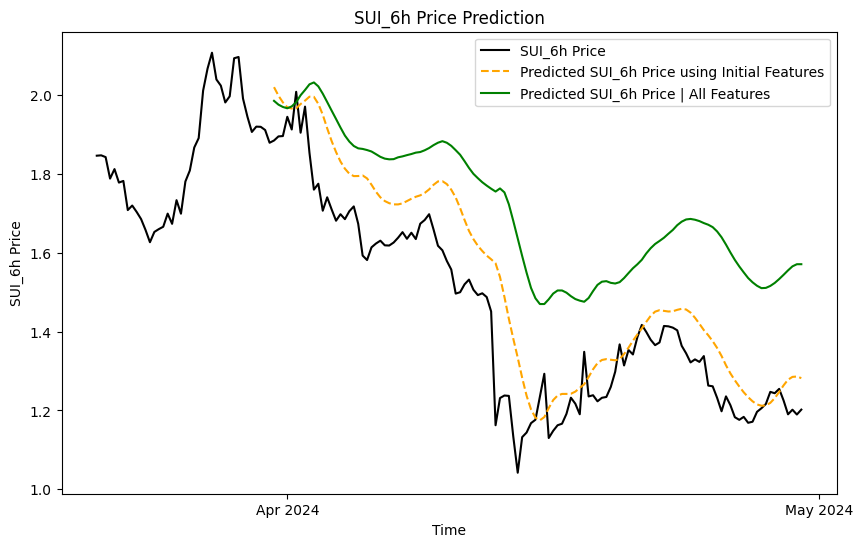

In [ ]:
# Visualize both price predictions at once
visualize_results2(df, models[0][1], models[1][1], date_validation, coin, seq_length=seq_length)

In [ ]:
print(models[0][0].metrics_names)
print(models[0][2])
print(models[1][0].metrics_names)
print(models[1][2])

['loss', 'mean_squared_error', 'root_mean_squared_error']
[0.006167123109723131, 0.0061671226, 0.07853103]
['loss', 'mean_squared_error', 'root_mean_squared_error']
[0.03588551754752795, 0.035885517, 0.18943472]
